In [1]:
# Dubbi:
#1 come mai le chiavi di a sembrano random?
#2 come faccio a non fare re-inserimento ?? Ricorda io estraggo d-1 cosi, più uno, più un altro che è quello di arrivo

In [162]:
import OffsetArrays
using Plots
using Revise
using ProgressMeter
using SparseArrays, LinearAlgebra, IndexedGraphs, Graphs
srcpath = "../src"
include("$srcpath/functions.jl")

avgAUC (generic function with 2 methods)

In [163]:
# S=0   I=1
# The times go from ti = 0 to ti=T+1
# when ti=0 it means that i is the zero patient
# when ti=T+1 it means that i is never infected

λp = 0.6 # planted infection rate
λi = 0.6 # inferred infection rate

d = 3 # degree (fixed for now) 
T = 4 # discrete time

γp = 0.35 # planted autoinfection probability
γi = 0.35 # inferred autoinfection probability

N = 5000; #population size

# Population dynamics for the messages

In [164]:
# Creation of the population
# we create μ as the set of all the N functions
# μ[k,ti,ck,τi,σk] is the value taken by the
# function μk with arguments ti,ck,τi,σk
# Using OffsetArrays we managed to keep notation 
# coherent with the notes: 

# i=1,...,N, 
# ti=0,...,T+1 
# c = 0,1
# σ=0,1,2

# The same is done for the ν function later
inizialization = ones(N,T+2,2,T+2,3) / (6*(T+2)^2)
μ = OffsetArrays.OffsetArray(inizialization,0,-1,-1,-1,-1);

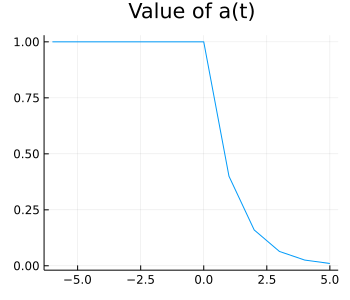

In [165]:
#Precalculation of the function a := (1-λ)^{tθ(t)}, 
#useful for later (the function a appears
#  in the inferred time factor node)

a = Dict(zip(-T-2:T+1,[ t<=0 ? 1 : (1-λi)^t for t = -T-2:T+1]));
μold = copy(μ);
plot(LinRange(-T-2,T+1,2T+4),[a[t] for t=-T-2:T+1],size=(350,300),legend=false,title="Value of a(t)")

In [166]:
ν = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1);
neighbours = rand(1:N,d-1);

In [167]:
tot_iterations = 40000
@showprogress for iterations = 1:tot_iterations
    # Extraction of disorder: state of individual i: xi0, delays: sij and sji

    xi0,sij,sji = rand_disorder(γp,λp)

    # Initialization of ν=0
    ν = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1)

    #Extraction of d-1 μ's from population
    neighbours = rand(1:N,d-1)

    #Beginning of calculations: we start by calculating the ν: 
    calculate_ν!(ν,μ,neighbours,xi0,T,γi,a)
    
    # Now we use the ν vector just calculated to extract the new μ.
    # We extract a population index that we call "l".
    # We overwrite the μ in postition μ[l,:,:,:,:]
    l = rand(1:N);

    # First we calculate and store the cumulated of ν with respect to 
    # planted time, i.e. the third argument. We call Σ this cumulated 
    Σ = cumsum(ν,dims=3)
    update_μ!(μ,ν,Σ,l,sij,sji,T,a)     
end

#p1=plot(reshape(sum(μ,dims=1) ./ N,864))
#p1=plot!(reshape(sum(μold,dims=1) ./ N,864))
#μold = copy(μ);
#plot(p1)

Progress: 100%|█████████████████████████████████████████| Time: 0:02:10


We plot the heatmaps of the messages

# From messages to marginals

In [168]:
p = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2),-1,-1,-1);
marg = OffsetArrays.OffsetArray(zeros(N,T+2,T+2),0,-1,-1);
max_count = N;

In [169]:
# Now we take out converged population of μ and use it to extract marginals.
# First we extract two ν's and then we combine it in order to obtain a marginal.
# In order to extract a ν we have to extract d-1 μ's. Therefore we extract two groups of 
# d-1 μ's and from them we calculate the two ν's. We also have to extract disorder.
@showprogress for l = 1:max_count
    group1 = rand(1:N,d-1) #groups of neighbours 
    group2 = rand(1:N,d-1)
    
    xi0,sij,sji = rand_disorder(γp,λp) #planted disorder
    xj0 = Int(rand() < γp);
    
    ν1 = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1)
    ν2 = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1)

    calculate_ν!(ν1,μ,group1,xi0,T,γi,a)
    calculate_ν!(ν2,μ,group2,xj0,T,γi,a)

    #Once the ν are calculated we have to cumulate with respect the third argument
    Σ = cumsum(ν2,dims=3)
    update_marginal!(marg,l,ν1,ν2,Σ,sij,sji,T)
end
marg2D = reshape((sum(marg,dims=1)./ max_count),T+2,T+2);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [170]:
include("$srcpath/functions.jl")

avgAUC (generic function with 2 methods)

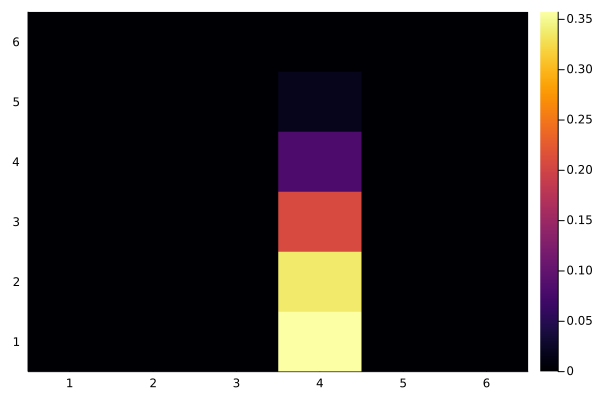

In [171]:
heatmap(reshape((marg[393,:,:]),T+2,T+2))

In [176]:
marg;

In [173]:
sum(marg[l+1,0:t,τj])

0.0

In [177]:
function avgAUC(marg)
    N = size(marg,1)
    T = size(marg,2) - 2
    AUC = OffsetArrays.OffsetArray(zeros(T+1),-1)
    count = OffsetArrays.OffsetArray(zeros(T+1),-1)
    for l = 1 : N - 1
        result = 0
        for τi = 0 : T
            (sum(marg[l, :, τi]) == 0 ) && continue
            for τj = τi + 1 : T + 1
                (sum(marg[l + 1, :, τj]) == 0) && continue
                #@show l,τi,τj
                #if you think at the perfect inference you understand that for t=τj you would sum the diagonal
                for t = τi : τj - 1
                    count[t] += 1
                    pi = sum(marg[l, 0:t, τi])
                    pj = sum(marg[l+1, 0:t, τj])
                    AUC[t] += (pi > pj)
                    #@show t,pi,pj
                end
            end
        end
    end
    return AUC ./ count
end

avgAUC (generic function with 2 methods)

In [178]:
avgAUC(marg)

5-element OffsetArray(::Vector{Float64}, 0:4) with eltype Float64 with indices 0:4:
 0.5158798283261803
 0.5127528583992964
 0.5830388692579506
 0.6709677419354839
 1.0

In [145]:
for h = 1:10
    h<100 && continue
    @show h
end

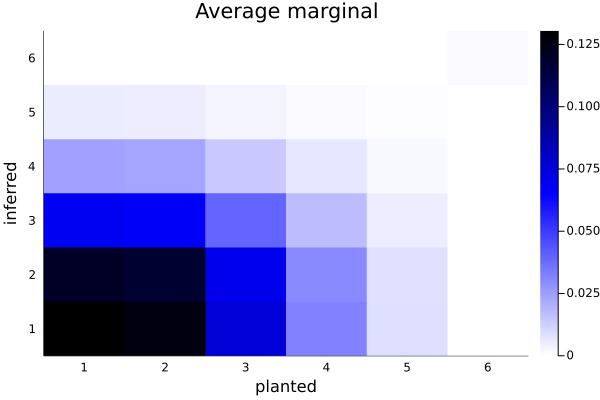

In [79]:
pheat = heatmap((marg2D),c=[:white,:blue,:black],xlabel="planted",ylabel="inferred",title="Average marginal")

In [94]:
sum([marg2D[t,t] for t=1:T+2])

0.2961156590804094

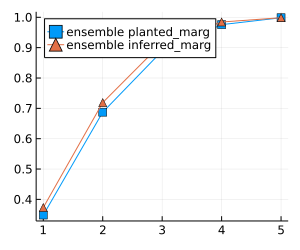

In [80]:
p0 = plot(cumsum(sum(marg2D,dims=1)'[1:end-1],dims=1),marker=:square,label="ensemble planted_marg")
p0 = plot!(cumsum(sum(marg2D,dims=2)[1:end-1],dims=1),marker=:utriangle,label="ensemble inferred_marg",legend=:bottomright)
plot(p0,size=(300,250),legend=:topleft)

# Single Instance Inferernce with Sib

## No disorder
In this regime we don't have disorder, in the sense that the planted distribution is a delta. The planted observation is "all infected"

## General framework with disorder
Here the results of observations change because the parameter regime is non trivial. Therefore we need to sample a planted configuration, observe this configuration at final time and infere the single instance. We do this many times and we average so to compare with the ensemble results

### Check of the planted distribution
Here we check with a sampler and with sibyl that the planted ensemble marginal is correct.

In [81]:
include("$srcpath/sampler.jl")
include("$srcpath/BP.jl")

Ngraph = 2500 # size of the single instance graph
x = zeros(Int,Ngraph, T + 1) # a single epidemic trajectory

# First we initialize a single instance marginal y
# which will be the average over graph and particles
# and epidemic trajectory of the marginals
y = zeros(T+1)
yBP = zero(y)
# we average over totst iterations
totst = 15
@showprogress for st = 1:totst
    # for every iteration we initialize a new graph
    G = random_regular_graph(Ngraph,d) |> IndexedBiDiGraph 
    # we sample an epidemic
    sample!(x, G, λp, γp)
    # we calculate the cumulative marginal (non-normalized)
    # and we sum it to the average marginal
    y .+= sum(x,dims=1)'
    p_sib = sibyl(Ngraph, T+1, G, [], γi, λi; maxit = 40, tol = 1e-2);
    avgmarg = sum(p_sib,dims=1)' ./ Ngraph
    yBP .+= avgmarg
end
#we normalize the average marginal
y ./= (Ngraph * totst)
yBP ./=  totst

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


sib.iterate(damp=0.0): 3/40 2.175e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.022e-04/0.01      
sib.iterate(damp=0.9): 0/40 5.110e-05/0.01      
sib.iterate(damp=0.0): 3/40 2.694e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.192e-04/0.01      
sib.iterate(damp=0.9): 0/40 5.961e-05/0.01      
sib.iterate(damp=0.0): 3/40 2.439e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.202e-04/0.01      
sib.iterate(damp=0.9): 0/40 6.011e-05/0.01      
sib.iterate(damp=0.0): 3/40 2.428e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.301e-04/0.01      
sib.iterate(damp=0.9): 0/40 6.504e-05/0.01      
sib.iterate(damp=0.0): 3/40 2.694e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.297e-04/0.01      
sib.iterate(damp=0.9): 0/40 6.485e-05/0.01      
sib.iterate(damp=0.0): 3/40 2.694e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.190e-04/0.01      
sib.iterate(damp=0.9): 0/40 5.951e-05/0.01      
sib.iterate(damp=0.0): 3/40 2.439e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.478e-04/0.01      
sib.iterate(damp=0.9

5-element Vector{Float64}:
 0.34999999999999964
 0.6795246500320465
 0.8862167292672197
 0.9731222484508334
 0.9958803037403567

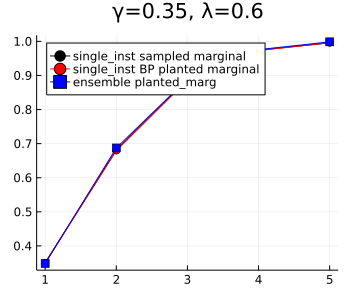

In [82]:
p0 = plot(y,c=:black,marker=:circle,label="single_inst sampled marginal",title="γ=$γp, λ=$λp")
p0 = plot!(yBP,c=:red,marker=:circle,label="single_inst BP planted marginal")
p0 = plot!(cumsum(sum(marg2D,dims=1)'[1:end-1],dims=1),c=:blue,marker=:square,size=(350,300),label="ensemble planted_marg",legend=:topleft)

### Comparison between inference (sibyl) and ensemble results
Here we check instead the results for the inferred marginal

In [83]:
yBP = zeros(T+1)
yBPerr = zero(yBP)
@showprogress for st = 1:totst
    # for every iteration we initialize a new graph
    G = random_regular_graph(Ngraph,d) |> IndexedBiDiGraph 
    # we sample an epidemic
    sample!(x, G, λp, γp)
    # observations set in the form of 
    # [(individual,state,observation time, false_rate of the test)]
    # where state ∈ {0,1} respectively for S and I
    # The reason why there is a T+1 is that sibyl starts from time 1 to time T. 
    # Instead the ensemble goes from time 0 to time T  
    O = [(i,x[i,T+1],T+1,1e-10) for i = 1:Ngraph]
    #we now run the BP algorithm for the single instance defined above
    p_sib = sibyl(Ngraph, T+1, G, O, γi, λi; maxit = 40, tol = 1e-2);
    yBP .+= sum(p_sib,dims=1)'
    yBPerr .+= sum(p_sib ,dims=1)' .^ 2
end

yBP ./= (Ngraph * totst)
yBPerr ./= (Ngraph^2 * totst)
yBPerr .= sqrt.(yBPerr .- yBP .^ 2) / sqrt(totst)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11



sib.iterate(damp=0.0): 4/40 9.667e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.664e-03/0.01      
sib.iterate(damp=0.9): 0/40 3.347e-03/0.01      
sib.iterate(damp=0.0): 4/40 9.182e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.730e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.366e-03/0.01      
sib.iterate(damp=0.0): 5/40 5.277e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.324e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.672e-03/0.01      
sib.iterate(damp=0.0): 4/40 7.057e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.510e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.292e-03/0.01      
sib.iterate(damp=0.0): 5/40 4.752e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.654e-03/0.01      
sib.iterate(damp=0.9): 0/40 8.513e-04/0.01      
sib.iterate(damp=0.0): 4/40 7.730e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.720e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.385e-03/0.01      
sib.iterate(damp=0.0): 5/40 6.956e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.684e-03/0.01      
sib.iterate(damp=0.

5-element Vector{Float64}:
 0.0007870099139110761
 0.001429738043638033
 0.001380262663084285
 0.0008716269037302768
 0.00042365603893470286

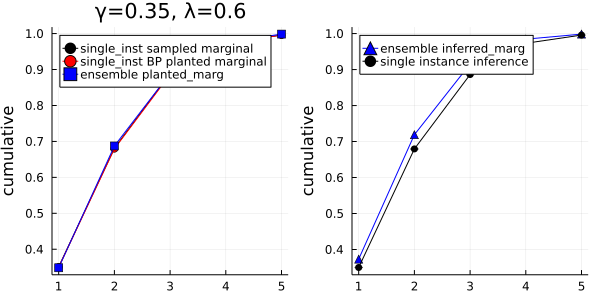

In [84]:
p1 = plot(cumsum(sum(marg2D,dims=2),dims=1)[1:end-1],c=:blue,marker=:utriangle,label="ensemble inferred_marg",legend=:bottomright)
p1 = plot!(yBP,yerr=yBPerr,c=:black,marker=:circle,label="single instance inference")
plot(p0,p1,size=(600,300),ylabel="cumulative",legend=:topleft)
#savefig("sibVSepid")

## 2D marginal comparison

In [85]:
function pdf(cdf_sib)
    N, T = size(cdf_sib) 
    p = zeros(N,T+1)
    p[:,1] .= cdf_sib[:,1]
    for t = 1:T-1
        p[:,t+1] .= cdf_sib[:,t+1] .- cdf_sib[:,t]
    end
    p[:,T+1] .= 1 .- cdf_sib[:,T]
    return p
end

pdf (generic function with 1 method)

In [218]:
include("../src/utils.jl")
totst = 10
AUC = zeros(T+1)
AUCerr = zeros(T+1)
sibylmarg2D = zeros(T+2,T+2)
@showprogress for st = 1:totst
    G = random_regular_graph(Ngraph,d) |> IndexedBiDiGraph 
    sample!(x, G, λp, γp)
    O = [(i,x[i,T+1],T+1,1e-10) for i = 1:Ngraph]
    p_sib = sibyl(Ngraph, T+1, G, O, γi, λi; maxit = 40, tol = 1e-2);
    sib_pdf = pdf(p_sib)
    for t = 1:T+1
        AUC[t] += AUROC(ROC(x[:,t], p_sib[:,t]))
        AUCerr[t] += AUROC(ROC(x[:,t], p_sib[:,t]))^2
    end
    tau = T .- sum(x,dims=2) .+ 2; #set of planted times
    for τ = 1:T+2
        sibylmarg2D[:,τ] .+= sum(sib_pdf .* (tau .== τ ),dims=1)' 
    end
end
AUC ./= totst 
AUCerr .= sqrt.((AUCerr./ totst  .- (AUC .^ 2))./ totst ) 
sibylmarg2D ./= (Ngraph*totst)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07



sib.iterate(damp=0.0): 4/40 7.374e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.301e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.238e-03/0.01      
sib.iterate(damp=0.0): 5/40 4.326e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.669e-03/0.01      
sib.iterate(damp=0.9): 0/40 8.315e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.160e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.696e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.353e-03/0.01      
sib.iterate(damp=0.0): 4/40 7.391e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.701e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.355e-03/0.01      
sib.iterate(damp=0.0): 5/40 5.152e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.210e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.115e-04/0.01      
sib.iterate(damp=0.0): 4/40 7.409e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.422e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.246e-03/0.01      
sib.iterate(damp=0.0): 5/40 3.248e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.632e-03/0.01      
sib.iterate(damp=0.

6×6 Matrix{Float64}:
 0.124454     0.118868     0.0717885    0.0287483    0.00649033   3.61447e-11
 0.116837     0.111715     0.0676924    0.0273153    0.00628736   3.4011e-11
 0.072367     0.0694506    0.0426746    0.0177851    0.00448216   2.13035e-11
 0.0293766    0.0284327    0.0180784    0.0081494    0.00270091   8.91315e-12
 0.00684621   0.00681337   0.00472603   0.00256189   0.00163923   2.22882e-12
 1.01027e-13  1.04919e-13  8.31182e-14  5.49623e-14  6.00398e-14  0.00372

In [219]:
AUC

5-element Vector{Float64}:
 0.521516699726211
 0.5250213555641426
 0.5586265261373494
 0.6462788318942956
 1.0

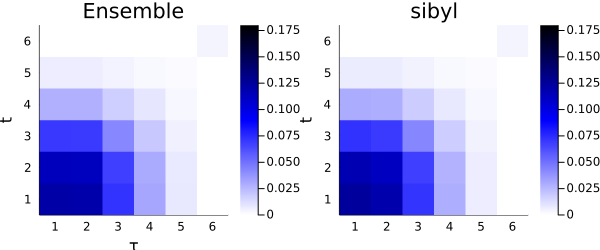

In [220]:
plot_sib = heatmap(sibylmarg2D,c=[:white,:blue,:black],csclxlabel="τ",ylabel="t",title="sibyl") 
plot_ens = heatmap(marg2D,c=[:white,:blue,:black],xlabel="τ",ylabel="t",title="Ensemble")
plot(plot_ens,plot_sib,size = (600,250),clims=(0,0.18))
#savefig("ensemble_VS_sibyl")

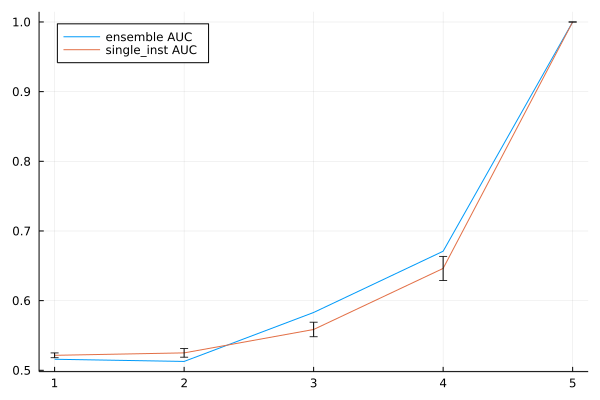

In [222]:
tmp = avgAUC(marg)
ensAUC = [tmp[t] for t=0:T]
plot(ensAUC,label="ensemble AUC")
AUCerr[end] = 0
plot!(AUC,label="single_inst AUC",legend=:topleft,yerr=AUCerr)
#savefig("AUC")

In [217]:
G = random_regular_graph(Ngraph,d) |> IndexedBiDiGraph 
    sample!(x, G, λp, γp)
    O = [(i,x[i,T+1],T+1,1e-10) for i = 1:Ngraph]
    p_sib = sibyl(Ngraph, T+1, G, O, γi, λi; maxit = 40, tol = 1e-2);
    sib_pdf = pdf(p_sib)  
    AUC = [AUROC(ROC(x[:,t], p_sib[:,t])) for t=1:T+1]


sib.iterate(damp=0.0): 4/40 7.796e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.639e-03/0.01      


5-element Vector{Float64}:
 0.5092919717278364
 0.5230508748815382
 0.5538541953489238
 0.6536748633879782
 1.0

In [180]:
avgAUC(marg)

5-element OffsetArray(::Vector{Float64}, 0:4) with eltype Float64 with indices 0:4:
 0.5158798283261803
 0.5127528583992964
 0.5830388692579506
 0.6709677419354839
 1.0